In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd

In [ ]:

X_test_filename = '/content/drive/MyDrive/IE434 Deep Dive 11 project/Deep Dive 4 (Milestone 3)/X_test.pkl'

with open(X_test_filename, 'rb') as file:
    X_test = pickle.load(file)

y_test_filename = '/content/drive/MyDrive/IE434 Deep Dive 11 project/Deep Dive 4 (Milestone 3)/y_test.pkl'

with open(y_test_filename, 'rb') as file:
    y_test = pickle.load(file)

y_test_df = '/content/drive/MyDrive/IE434 Deep Dive 11 project/Deep Dive 4 (Milestone 3)/y_test_numerical.pkl'

with open(y_test_df, 'rb') as file:
    y_test_df = pickle.load(file)



# ImprovedGRUModel Class

The `ImprovedGRUModel` class is a PyTorch neural network module, inheriting from `nn.Module`. It is designed to implement an improved version of the GRU (Gated Recurrent Unit) model, suitable for sequence modeling tasks. The class is structured as follows:

- Initializes the model with the following parameters:
  - `input_size`: The number of expected features in the input `x`.
  - `hidden_size`: The number of features in the hidden state `h`.
  - `output_size`: The number of features in the output.
  - `num_layers`: Number of recurrent layers (default is 1).
  - `dropout_rate`: If non-zero, introduces a dropout layer on the outputs of each GRU layer except the last layer (default is 0.2).
- The constructor sets up the following layers:
  - A GRU layer.
  - A dropout layer.
  - A fully connected (linear) layer.

## GRU Layer
- Defined using `nn.GRU`, it processes the input sequence.
- Applies dropout between layers if `num_layers` is more than 1.

## Dropout Layer
- Implemented using `nn.Dropout`, it randomly zeros some of the elements of the input tensor with probability `dropout_rate`.

## Fully Connected Layer
- A linear layer (`nn.Linear`) that maps the hidden state output of the GRU to the output size.

## Method: `forward(self, x, hidden)`
- Defines the forward pass of the model.
- Takes `x` (input) and `hidden` (initial hidden state) as inputs.
- Applies the GRU layer, followed by dropout, and then passes the output through the fully connected layer.
- Returns the output and the hidden state.

## Method: `init_hidden(self, batch_size)`
- Initializes the hidden state of the GRU.
- Returns a tensor of zeros with shape `(num_layers, batch_size, hidden_size)`.


In [ ]:
class ImprovedGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.2):
        super(ImprovedGRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU Layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=(dropout_rate if num_layers > 1 else 0))

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected Layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)

        # Applying dropout to the output of the last GRU layer
        out = self.dropout(out)

        # Reshape output for the fully connected layer
        out = out.reshape(-1, self.hidden_size)

        # Get the final output
        out = self.fc(out)

        return out, hidden

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden




## Function: `calculate_accuracy(conf_matrix)`
This function calculates the accuracy of a model based on a confusion matrix.
- **Parameter:** `conf_matrix` - a confusion matrix of the model predictions.
- **Returns:** The accuracy, calculated as the ratio of correctly predicted instances (the trace of the confusion matrix) to the total number of instances (the sum of all elements in the confusion matrix).

## Function: `evaluate_feature_importance(model, X_test_tensor, y_test_tensor, batch_size=64, call_time=1)`
This function evaluates the importance of each feature in a dataset for a given model's predictions.
- **Parameters:**
  - `model`: The trained model to evaluate.
  - `X_test_tensor`: Test data features as a tensor.
  - `y_test_tensor`: Test data labels as a tensor.
  - `batch_size`: Batch size for the DataLoader (default is 64).
  - `call_time`: A seed for reproducibility of results (default is 1).
- **Process:**
  - First, the function calculates the model's accuracy on the original test data without any alteration.
  - It then iteratively shuffles each feature (column) of the test data, evaluates the model's accuracy with this shuffled data, and records the accuracy.
  - A decrease in accuracy after shuffling a particular feature implies the importance of that feature for the model's predictions.
- **Visualizations:**
  - It plots two graphs:
    - The first graph shows the accuracy for each shuffled column compared to the original accuracy.
    - The second graph displays the decrease in accuracy for each shuffled column.
- **Returns:** A tuple containing:
  - `column_accuracies`: A list of accuracies for each shuffled column.
  - `accuracy_decrease`: A list representing the decrease in accuracy for each shuffled column compared to the original accuracy.

### Additional Notes:
- The function uses PyTorch's `DataLoader` and `TensorDataset` for batch processing of the test data.
- `torch.no_grad()` is used to disable gradient calculations, saving memory and computations during the evaluation phase.
- The function uses `confusion_matrix` (likely from a library like scikit-learn) to calculate the confusion matrix for each test set variant.
- The visualization is performed using matplotlib, a popular plotting library in Python.

This function is useful for understanding which features are most influential for the model's predictions, which can be crucial for feature selection and model interpretation.

In [ ]:
def calculate_accuracy(conf_matrix):
    return np.trace(conf_matrix) / np.sum(conf_matrix)

def evaluate_feature_importance(model, X_test_tensor, y_test_tensor, batch_size=64, call_time=1):
    # DataLoader for test set
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

    # confusion matrix and accuracy on ORIGINAL test data
    model.eval()
    all_predictions = []
    all_true_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            # launch model and prediction
            batch_size = X_batch.size(0)
            hidden = model.init_hidden(batch_size)
            output, hidden = model(X_batch.unsqueeze(1), hidden)
            predictions = output.argmax(dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(y_batch.cpu().numpy())

    original_conf_matrix = confusion_matrix(all_true_labels, all_predictions)
    original_accuracy = calculate_accuracy(original_conf_matrix)

    # python list to store accuracy based on each row's permutation
    column_accuracies = []

    # Permutation of each columns of X_test_tensor
    torch.manual_seed(call_time)
    for column in range(X_test_tensor.size(1)):
        shuffled_X_test = X_test_tensor.clone()
        shuffled_indices = torch.randperm(shuffled_X_test.size(0))
        shuffled_X_test[:, column] = shuffled_X_test[shuffled_indices, column]

        # DataLoader for shuffled test set
        shuffled_test_loader = DataLoader(TensorDataset(shuffled_X_test, y_test_tensor), batch_size=batch_size, shuffle=False)

        # launch model and confusion matrix based on newly shuffled dataset
        all_predictions = []
        all_true_labels = []
        with torch.no_grad():
            for X_batch, y_batch in shuffled_test_loader:
                batch_size = X_batch.size(0)
                hidden = model.init_hidden(batch_size)
                output, hidden = model(X_batch.unsqueeze(1), hidden)
                predictions = output.argmax(dim=1)
                all_predictions.extend(predictions.cpu().numpy())
                all_true_labels.extend(y_batch.cpu().numpy())

        conf_matrix = confusion_matrix(all_true_labels, all_predictions)
        accuracy = calculate_accuracy(conf_matrix)
        column_accuracies.append(accuracy)

    # Visualize Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(column_accuracies, label='Shuffled Column Accuracy')
    plt.axhline(y=original_accuracy, color='r', linestyle='--', label='Original Accuracy')
    plt.xlabel('Column Index')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Shuffled Column')
    plt.legend()
    plt.show()

    # Visualize Accuracy Descent by permutation
    accuracy_decrease = [original_accuracy - acc for acc in column_accuracies]
    decreased_order_accuracy_decrease = sorted(accuracy_decrease)
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(accuracy_decrease)), accuracy_decrease)
    plt.xlabel('Column Index')
    plt.ylabel('Decrease in Accuracy')
    plt.title('Decrease in Accuracy per Shuffled Column')
    plt.show()

    return column_accuracies, accuracy_decrease

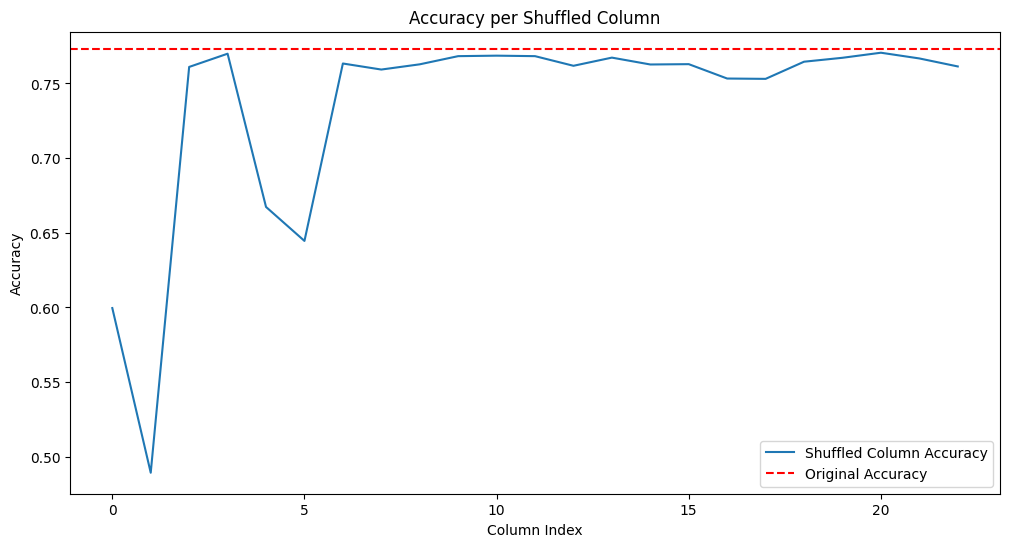

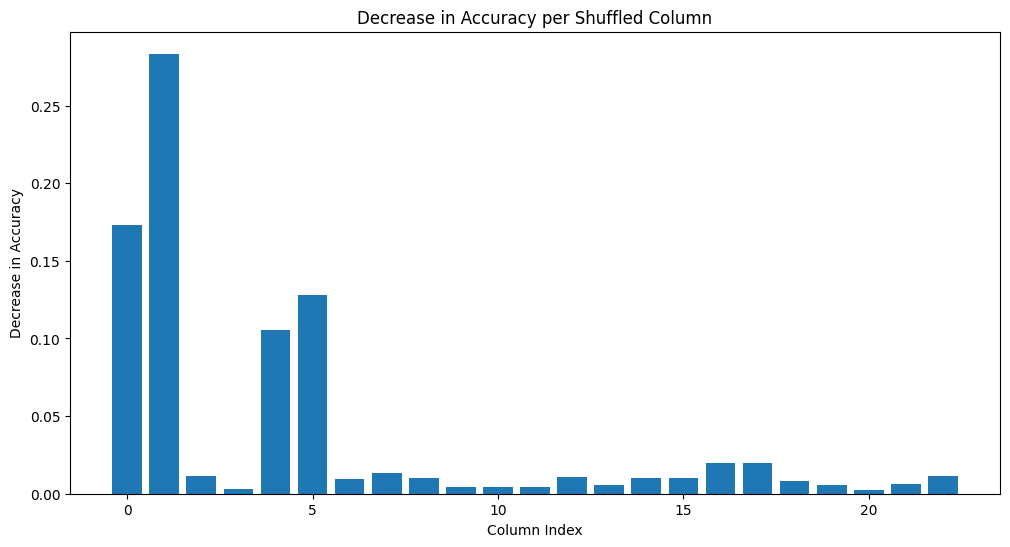

In [ ]:

# Convert X_test DataFrame to PyTorch tensor
X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test_df.values).long()  # Directly use y_test if it's already encoded

# Load the model
model_GRU = torch.load('/content/drive/MyDrive/IE434 Deep Dive 11 project/Deep Dive 4 (Milestone 3)/best_model_GRU.pth')
model_GRU.eval()

# call function to evaluate feature importance
column_accuracies, accuracy_decrease = evaluate_feature_importance(model_GRU, X_test_tensor, y_test_tensor, batch_size=64)


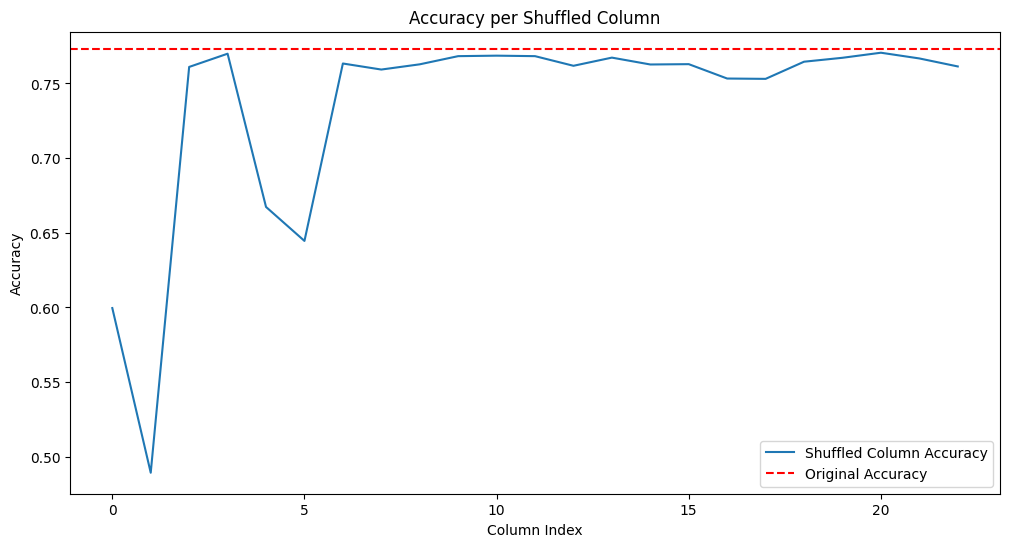

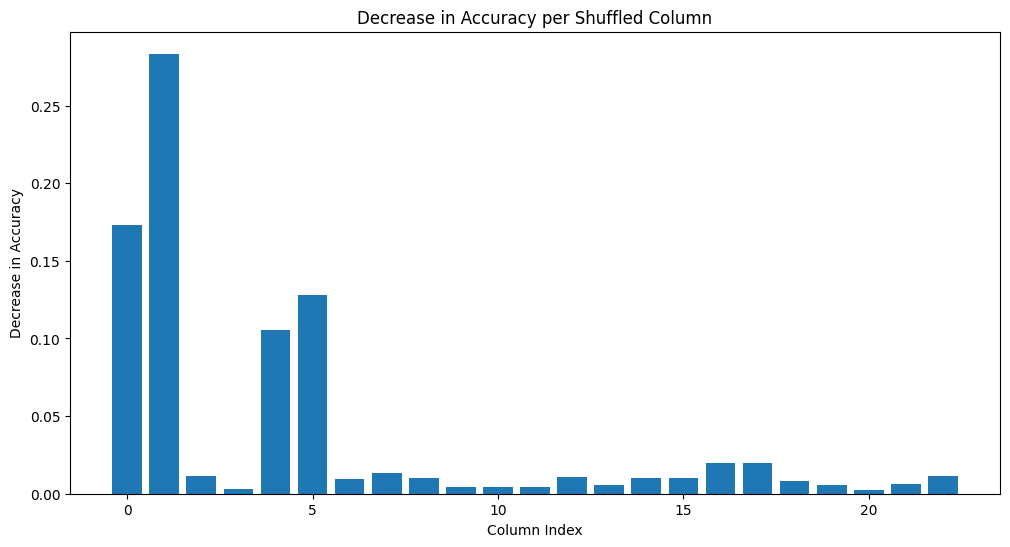

Average Column Accuracies: [0.5996281714785652, 0.48939195100612426, 0.7610454943132109, 0.7699037620297463, 0.6673228346456693, 0.644575678040245, 0.76334208223972, 0.7592957130358705, 0.7627952755905512, 0.7682633420822397, 0.768591426071741, 0.7682633420822397, 0.7618110236220472, 0.7672790901137357, 0.7626859142607174, 0.7629046369203849, 0.7532808398950132, 0.7530621172353456, 0.7645450568678915, 0.767169728783902, 0.7705599300087489, 0.7667322834645669, 0.7613735783027121]
Average Accuracy Decrease: [0.1731189851268592, 0.2833552055993001, 0.011701662292213477, 0.00284339457567806, 0.10542432195975504, 0.1281714785651794, 0.009405074365704369, 0.013451443569553856, 0.00995188101487321, 0.004483814523184693, 0.004155730533683344, 0.004483814523184693, 0.010936132983377145, 0.005468066491688628, 0.010061242344706955, 0.009842519685039464, 0.019466316710411213, 0.019685039370078816, 0.00820209973753283, 0.005577427821522374, 0.0021872265966754734, 0.0060148731408574685, 0.0113735783

In [ ]:
def average_lists(lists):
    """ Function to calculate the average of given lists """
    # Sum the corresponding elements of the lists
    summed = [sum(values) for values in zip(*lists)]
    # Calculate the average
    return [s / len(lists) for s in summed]

# Number of calls
num_calls = 1

# Lists to store list of accuracies, accuracy_decrease
all_column_accuracies = []
all_accuracy_decreases = []

# Call the function multiple times and store the results
for _ in range(num_calls):
    column_accuracies, accuracy_decrease = evaluate_feature_importance(model_GRU, X_test_tensor, y_test_tensor, batch_size=64,call_time=num_calls)
    all_column_accuracies.append(column_accuracies)
    all_accuracy_decreases.append(accuracy_decrease)

# Calculate the averages
avg_column_accuracies = average_lists(all_column_accuracies)
avg_accuracy_decrease = average_lists(all_accuracy_decreases)

# Print the results
print("Average Column Accuracies:", avg_column_accuracies)
print("Average Accuracy Decrease:", avg_accuracy_decrease)



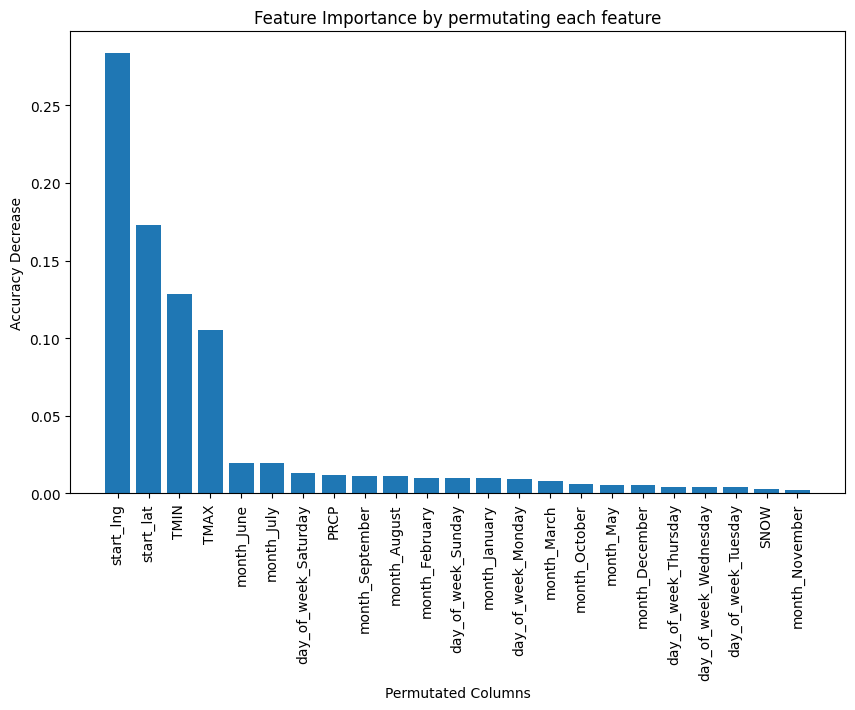

In [ ]:

# Average Column Accuracy Decrease
avg_accuracy_decrease = pd.DataFrame(avg_accuracy_decrease).T
avg_accuracy_decrease.columns = X_test.columns
avg_accuracy_decrease = avg_accuracy_decrease.T
avg_accuracy_decrease = avg_accuracy_decrease.sort_values(by=0, ascending=False)
avg_accuracy_decrease = avg_accuracy_decrease.T
plt.figure(figsize=(10, 6))
plt.bar(avg_accuracy_decrease.columns, avg_accuracy_decrease.iloc[0])
plt.xlabel('Permutated Columns')
plt.ylabel('Accuracy Decrease')
plt.title('Feature Importance by permutating each feature')
plt.xticks(rotation=90)
plt.show()